In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Test Matrix

Test Matrix below was used to debug and test the performance before applying it to the actual matrix.
The matrix is a sparse integer matrix of 100 users by 50 items.

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create a user-item interaction matrix (100 users, 50 items) with sparsity
num_users = 10000
num_items = 500
interaction_matrix = np.random.randint(0, 6, size=(num_users, num_items))  # Random interactions from 0 to 5

# Introduce sparsity by setting a high percentage of interactions to 0
sparsity = 0.8  # 80% of the interactions will be set to 0
mask = np.random.rand(*interaction_matrix.shape) < sparsity
interaction_matrix[mask] = 0
df = pd.DataFrame(interaction_matrix)
df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,3,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
1,0,5,0,0,0,1,5,0,0,0,...,0,0,0,0,4,5,4,0,0,4
2,0,0,0,0,0,0,2,0,5,5,...,0,0,0,0,0,0,0,0,0,5
3,0,1,3,0,0,0,2,2,0,4,...,0,0,0,0,0,0,0,4,0,0
4,0,5,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,2,0,0,4,0,2,0,0,0,...,0,0,0,0,0,0,0,1,0,2
9996,5,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,5,4,0,0
9997,1,0,0,4,0,0,0,0,0,0,...,0,0,5,4,0,5,0,0,0,5
9998,0,0,2,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


In [4]:
def convert_test_to_coo(df):
    rows, cols = np.where(df.values != 0)
    data = df.values[rows, cols]
    coo = coo_matrix((data, (rows, cols)), shape=df.shape)
    return coo

In [5]:
def convert_df_coo(df):
    user_mapping = {user_id: idx for idx, user_id in enumerate(df['User_id'].unique())}
    book_mapping = {book_id: idx for idx, book_id in enumerate(df['book_id'].unique())}
    
    # Map the User_id and book_id columns to their integer indices
    df['user_idx'] = df['User_id'].map(user_mapping)
    df['book_idx'] = df['book_id'].map(book_mapping)
    
    # Create the COO matrix
    row = df['user_idx'].values
    col = df['book_idx'].values
    data = df['review/score'].values
    num_users = len(user_mapping)
    num_books = len(book_mapping)
    
    coo = coo_matrix((data, (row, col)), shape=(num_users, num_books))
    return coo

In [24]:
class AutoEncoder(nn.Module):
	def __init__(self, input_dim, bottleneck_size, device='cpu'):
		super(AutoEncoder, self).__init__()
		self.device = device
		self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2048),
			nn.ReLU(),
            nn.Linear(2048, 1024),
			nn.ReLU(),
			nn.Linear(1024, 512),
			nn.ReLU(),
			nn.Linear(512, 256),
			nn.ReLU(),
			nn.Linear(256, bottleneck_size)
		)
		self.decoder = nn.Sequential(
			nn.Linear(bottleneck_size, 256),
			nn.ReLU(),
			nn.Linear(256, 512),
			nn.ReLU(),
			nn.Linear(512, 1024),
            nn.ReLU(),
			nn.Linear(1024, 2048),
            nn.ReLU(),
			nn.Linear(2048, input_dim)
		)
	
	def forward(self, x):
		x = self.encoder(x)
		x = self.decoder(x)
		return x
	
	def fit(self, batches, n_epochs=100, min_delta=0.0001, lr=0.001, patience=10):
		optimizer = torch.optim.Adam(self.parameters(), lr=lr)
		criterion = nn.MSELoss()
		best_loss = float('inf')
		patience_counter = 0
		epoch_losses = []
		epochs = []

		for epoch in range(n_epochs):
			epoch_loss = 0.0
			for batch in batches:
				batch = batch[0].to(self.device)  # Move batch to device
				optimizer.zero_grad()
				output = self.forward(batch)
				loss = criterion(output, batch)
				loss.backward()
				optimizer.step()
				epoch_loss += loss.item()
		
			epoch_loss /= len(batches)

			if epoch_loss < best_loss - min_delta:
				best_loss = epoch_loss
				patience_counter = 0
			else:
				patience_counter += 1

			if patience_counter >= patience:
				print(f"Early stopping at epoch {epoch+1} with loss {epoch_loss:.4f}")
				break
			epoch_losses.append(epoch_loss)
			epochs.append(epoch+1)
			print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}')
		return epochs, epoch_losses


In [7]:
def fit_by_bottleneck(user_ratings: pd.DataFrame, device: torch.device, bottleneck: int = 10):

    # Create the COO matrix
    coo = convert_df_coo(user_ratings)
    
    dense_matrix = torch.tensor(coo.toarray(), dtype=torch.float32).to(device)
    dataset = TensorDataset(dense_matrix)
    model = AutoEncoder(dense_matrix.shape[1], bottleneck, device=device).to(device)
    batch_size = 128
    
    batches = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    epochs, losses = model.fit(batches, n_epochs=1000, lr=0.0001, patience=20)
    
    pd.DataFrame({"epochs": epochs, "training losses": losses}).to_csv(f'models/training_losses/{bottleneck}.csv')
    torch.save(model, f'models/model/model_k={bottleneck}.pt')
    torch.save(model.state_dict(), f'models/weights/smodel_k_weights_{bottleneck}.pt')

In [8]:
coo = convert_test_to_coo(df)
dense_matrix = torch.tensor(coo.toarray(), dtype=torch.float32).to(device)
dataset = TensorDataset(dense_matrix)
bottleneck_size = 256
batch_size = 256
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
model = AutoEncoder(num_items, bottleneck_size, device=device).to(device)

In [10]:
import matplotlib.pyplot as plt

Epoch [1/1000], Loss: 2.5555
Epoch [2/1000], Loss: 1.5835
Epoch [3/1000], Loss: 1.5820
Epoch [4/1000], Loss: 1.5838
Epoch [5/1000], Loss: 1.5788
Epoch [6/1000], Loss: 1.5789
Epoch [7/1000], Loss: 1.5811
Epoch [8/1000], Loss: 1.5793
Epoch [9/1000], Loss: 1.5801
Epoch [10/1000], Loss: 1.5819
Epoch [11/1000], Loss: 1.5823
Epoch [12/1000], Loss: 1.5807
Epoch [13/1000], Loss: 1.5816
Epoch [14/1000], Loss: 1.5785
Epoch [15/1000], Loss: 1.5780
Epoch [16/1000], Loss: 1.5794
Epoch [17/1000], Loss: 1.5805
Epoch [18/1000], Loss: 1.5805
Epoch [19/1000], Loss: 1.5786
Epoch [20/1000], Loss: 1.5795
Epoch [21/1000], Loss: 1.5801
Epoch [22/1000], Loss: 1.5749
Epoch [23/1000], Loss: 1.5776
Epoch [24/1000], Loss: 1.5791
Epoch [25/1000], Loss: 1.5748
Epoch [26/1000], Loss: 1.5752
Epoch [27/1000], Loss: 1.5762
Epoch [28/1000], Loss: 1.5740
Epoch [29/1000], Loss: 1.5735
Epoch [30/1000], Loss: 1.5760
Epoch [31/1000], Loss: 1.5741
Epoch [32/1000], Loss: 1.5760
Epoch [33/1000], Loss: 1.5764
Epoch [34/1000], Lo

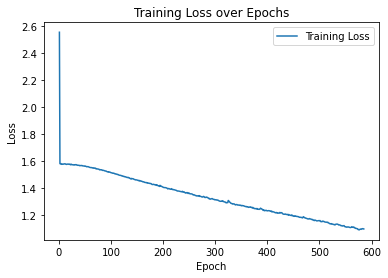

In [11]:
# Train the model
epochs, epoch_losses = model.fit(train_loader, n_epochs=1000, lr=0.001, patience=10)

# Plot the training loss over epochs
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [14]:
# res = test_sample_model(model, df, device)
model.eval()
sample_coo = convert_test_to_coo(df)
with torch.no_grad():
    sample_tensor = torch.tensor(sample_coo.toarray(), dtype=torch.float32, device=device)
masked = mask_sample(sample_tensor, 0.2, device)
res = model(masked)
print(res)
print(sample_tensor)


tensor([[ 1.1650, -0.2889,  0.8617,  ...,  0.9054,  1.4898, -0.1616],
        [ 0.3516,  0.1389,  1.2598,  ...,  0.0185,  0.5684,  0.0644],
        [ 1.9178, -0.1507, -1.0456,  ...,  0.7214,  0.5457,  0.3084],
        ...,
        [ 0.5471,  0.3937,  0.5527,  ...,  0.3969,  0.7683,  0.6705],
        [ 1.8080,  1.2988,  0.3938,  ...,  0.9211,  2.0709,  1.0087],
        [-0.0679,  0.4395,  0.7160,  ...,  0.3078,  1.0067,  0.5451]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[3., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 4.],
        [0., 0., 0.,  ..., 0., 0., 5.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 5.],
        [0., 0., 2.,  ..., 0., 3., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [17]:
loss = nn.MSELoss()
loss(res, sample_tensor)

tensor(1.4632, device='cuda:0', grad_fn=<MseLossBackward0>)

### Training the autoencoders

We then trained the model using LambdaLab's nvidia A10 gpu VM instance. 

In [8]:
model = None

Note: `testing_mode` is a checkpoint variable to signify that we are testing the model on the local end. If set to false, it will train the model.

In [9]:
testing_mode = False

In [10]:
user_ratings = pd.read_csv('ratings_user_tagged.csv.gzip',compression='gzip')
# user_ratings = user_ratings.fillna(0)

In [11]:
user_ratings

,Unnamed: 0,User_id,review/score,book_id
0,1,A30TK6U7DNS82R,5.0,0826414346
1,3,A2MVUWT453QH61,4.0,0826414346
2,5,A2F6NONFUDB6UK,4.0,0826414346
3,6,A14OJS0VWMOSWO,5.0,0826414346
4,11,A373VVEU6Z9M0N,5.0,0829814000
...,...,...,...,...
406027,34950,A2PK3NTC9RMEF4,3.0,0786182431
406028,34958,A32ZKBXJJ45BRY,3.0,B00085PL4C
406029,34967,A25JH6CO4DVINS,4.0,0255364520
406030,34969,AOFGOUMXLMVZS,4.0,B000NSLVCU


In [12]:
user_ratings['User_id'].unique().shape[0]

6842

After training on the vm, we tested the autoencoder performance against SVD and the actual value.

In [25]:
bottlenecks = [128]

For training, we used the batch size of 128 and parameters of 1000 epoch, learning rate of 0.001.

In [26]:
import os
%timeit
if testing_mode:
	print('Tested')
# check if folder exists
# elif os.path.isdir('models'):
# 	model = torch.load('amazon_model.pt')
# 	model.load_state_dict(torch.load('amazon_model_weights.pt'))
else:
    batch_size = 128
    for bottleneck in bottlenecks:
        print(f"=== training k={bottleneck} model ===\n")
        os.makedirs('models', exist_ok=True)
        os.makedirs('models/weights', exist_ok=True)
        os.makedirs('models/model', exist_ok=True)
        fit_by_bottleneck(user_ratings, device, bottleneck)
        print(f"=== training k={bottleneck} model complete===")


=== training k=128 model ===

Epoch [1/1000], Loss: 0.0134
Epoch [2/1000], Loss: 0.0132
Epoch [3/1000], Loss: 0.0131
Epoch [4/1000], Loss: 0.0130
Epoch [5/1000], Loss: 0.0130
Epoch [6/1000], Loss: 0.0130
Epoch [7/1000], Loss: 0.0129
Epoch [8/1000], Loss: 0.0131
Epoch [9/1000], Loss: 0.0130
Epoch [10/1000], Loss: 0.0129
Epoch [11/1000], Loss: 0.0129
Epoch [12/1000], Loss: 0.0134
Epoch [13/1000], Loss: 0.0130
Epoch [14/1000], Loss: 0.0129
Epoch [15/1000], Loss: 0.0129
Epoch [16/1000], Loss: 0.0129
Epoch [17/1000], Loss: 0.0129
Epoch [18/1000], Loss: 0.0128
Epoch [19/1000], Loss: 0.0129
Epoch [20/1000], Loss: 0.0132
Epoch [21/1000], Loss: 0.0130
Epoch [22/1000], Loss: 0.0130
Epoch [23/1000], Loss: 0.0129
Epoch [24/1000], Loss: 0.0129
Epoch [25/1000], Loss: 0.0130
Epoch [26/1000], Loss: 0.0130
Epoch [27/1000], Loss: 0.0130
Epoch [28/1000], Loss: 0.0129
Epoch [29/1000], Loss: 0.0129
Early stopping at epoch 30 with loss 0.0129
=== training k=128 model complete===


In [15]:
torch.cuda.empty_cache()

In [27]:
from numpy import linalg

In [28]:
# def test_sample_model(model: AutoEncoder, interaction_matrix: pd.DataFrame, device: torch.device, sample_size: int = 10):
# 	model.eval()
	
# 	sampled = interaction_matrix.sample(sample_size)
# 	display(sampled)
# 	tested = sampled.apply(lambda row: mask_test_model(model, 0.2, torch.tensor(row.to_numpy(), dtype=torch.float32, device=device)[0], device), axis=0).to_numpy()
# 	# s = torch.tensor(sampled)
# 	return linalg.norm(sampled.to_numpy() - tested, ord='fro'), tested

## Model Performance 

Now, we can test the performance for each model

In [29]:
def get_mappings(df, user_col='User_id', book_col='book_id'):
    """
    Generate mappings from user and book labels to integer indices.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing user and book columns.
    - user_col (str): Name of the user column in the DataFrame.
    - book_col (str): Name of the book column in the DataFrame.
    
    Returns:
    - user_mapping (dict): Mapping from user labels to integer indices.
    - book_mapping (dict): Mapping from book labels to integer indices.
    """
    user_mapping = {user_id: idx for idx, user_id in enumerate(df[user_col].unique())}
    book_mapping = {book_id: idx for idx, book_id in enumerate(df[book_col].unique())}
    
    return user_mapping, book_mapping


In [30]:
def get_value_from_coo(coo, user_label, book_label, user_mapping, book_mapping):
    """
    Get the value from a COO matrix using user and book labels.
    
    Parameters:
    - coo (coo_matrix): The COO matrix.
    - user_label (str): The user label.
    - book_label (str): The book label.
    - user_mapping (dict): Mapping from user labels to integer indices.
    - book_mapping (dict): Mapping from book labels to integer indices.
    
    Returns:
    - value (float or None): The value from the COO matrix, or None if not found.
    """
    user_idx = user_mapping.get(user_label)
    book_idx = book_mapping.get(book_label)
    if user_idx is not None and book_idx is not None:
        # Convert to CSR format to make element access efficient
        coo_csr = coo.tocsr()
        return coo_csr[user_idx, book_idx]
    else:
        return None


In [31]:
def mask_sample(tensor: torch.Tensor, mask_fraction: float, device: torch.device):
    tensor = tensor.to(device)
    masked_tensor = tensor.clone()

    # Identify non-zero elements in the tensor
    non_zero_indices = (tensor != 0).nonzero(as_tuple=False)

    # Determine the number of elements to mask
    num_non_zeros = non_zero_indices.size(0)
    num_to_mask = int(mask_fraction * num_non_zeros)

    if num_to_mask > 0:
        # Randomly select indices to mask
        mask_indices = torch.randperm(num_non_zeros)[:num_to_mask]

        # Apply the mask
        masked_tensor[non_zero_indices[mask_indices, 0], non_zero_indices[mask_indices, 1]] = 0

    return masked_tensor

In [32]:
def test_sample_model(model: nn.Module, user_ratings: pd.DataFrame, device: torch.device):
    model.eval()
    sample_coo = convert_df_coo(user_ratings)
    
    # Convert the COO matrix to a dense tensor
    sample_tensor = torch.tensor(sample_coo.toarray(), dtype=torch.float32, device=device)
    
    # Mask the sample tensor
    masked_sample = mask_sample(sample_tensor, 0.2, device)
    
    # Get the model's predictions
    with torch.no_grad():
        result_tensor = model(masked_sample).cpu().detach().numpy()
    
    # Extract the non-zero elements from the result tensor
    result_values = result_tensor[sample_coo.row, sample_coo.col]
    
    # Create the result COO matrix using the same row and column indices
    result_coo = coo_matrix((result_values, (sample_coo.row, sample_coo.col)), shape=sample_coo.shape)
    
    # Calculate the RMSE
    mse = np.mean((sample_tensor.cpu().numpy() - result_tensor) ** 2)
    loss = np.sqrt(mse)
    
    return loss, result_coo, sample_coo

In [33]:
def test_bottleneck(user_ratings: pd.DataFrame, device: torch.device, bottleneck: int = 10):
    print(f'Testing bottleneck {bottleneck}')
    model = torch.load(f'models/model/model_k={bottleneck}.pt')
    model.load_state_dict(torch.load(f'models/weights/smodel_k_weights_{bottleneck}.pt'))
    return test_sample_model(model, user_ratings, device)

### Results

### Training Loss

In [34]:
import matplotlib.pyplot as plt
def plot_training_loss(bottleneck: int):
	loss = pd.read_csv(f'models/training_losses/{bottleneck}.csv')
	plt.plot(loss['epochs'], loss['training losses'])
	plt.title(f'Training Loss for Bottleneck Size {bottleneck}')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	

For each bottleneck, we found the training loss as show below:

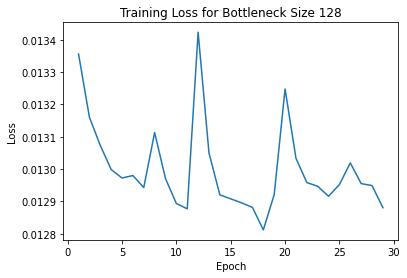

In [35]:
fig, ax = plt.subplots()
for bottleneck in bottlenecks:
	
	plot_training_loss(bottleneck)
	plt.show()

### Performance

We then tested the performances on each bottleneck.

In [32]:
# sample = user_ratings.sample(100)

We used the masking technique on the rows for each bottleneck.

In [24]:
bottleneck_results = [test_bottleneck(user_ratings, device, k) for k in bottlenecks]
# bottleneck_results = test_bottleneck(user_ratings, device, 5)

Testing bottleneck 256


counted how many rows that match the original one. The resulting `coo_matrix` shows

In [25]:
user_mapping, book_mapping = get_mappings(user_ratings)

In [28]:
# performance_results = pd.DataFrame(columns=['RMSE', 'Non-Zero Count'])
for result in bottleneck_results:
    print(f'RMSE: {result[0]:.4f}')
    user_label = 'A30TK6U7DNS82R'
    book_label = '0826414346'
    value = get_value_from_coo(result[1], user_label, book_label, user_mapping, book_mapping)
    print(f"Predicted for user '{user_label}' and book '{book_label}': {value}")
    value = get_value_from_coo(result[2], user_label, book_label, user_mapping, book_mapping)
    print(f"Value for user '{user_label}' and book '{book_label}': {value}")


RMSE: 0.1147
Predicted for user 'A30TK6U7DNS82R' and book '0826414346': 0.002719633746892214
Value for user 'A30TK6U7DNS82R' and book '0826414346': 5.0


So, the RMSE, the trainig loss and inference in the sample reveals bottleneck size of 16 is the optimal choice.

In [66]:
test16 = True

In [71]:
import pickle
if not test16:
    b16result = bottleneck_results[1]
    pickle.dump(b16result, open('k=16.pkl', 'wb'))
else:
    file = open('k=16.pkl', 'rb')
    b16result = pickle.load(file)
    

In [72]:
b16result

(0.10208989,
 <6842x92327 sparse matrix of type '<class 'numpy.float32'>'
 	with 406032 stored elements in COOrdinate format>,
 <6842x92327 sparse matrix of type '<class 'numpy.float64'>'
 	with 406032 stored elements in COOrdinate format>)

### Denoising Autoencoder

### PCA and k-means clustering

So, the data analyis

# :Autoencoder Implementation

To implement the autoencoder, we chose Pytorch for its similarity to numpy and compatibility to gpus.

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from scipy.sparse import coo_matrix

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Test Matrix

Test Matrix below was used to debug and test the performance before applying it to the actual matrix.
The matrix is a sparse integer matrix of 100 users by 50 items.

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create a user-item interaction matrix (100 users, 50 items) with sparsity
num_users = 10000
num_items = 500
interaction_matrix = np.random.randint(0, 6, size=(num_users, num_items))  # Random interactions from 0 to 5

# Introduce sparsity by setting a high percentage of interactions to 0
sparsity = 0.8  # 80% of the interactions will be set to 0
mask = np.random.rand(*interaction_matrix.shape) < sparsity
interaction_matrix[mask] = 0
df = pd.DataFrame(interaction_matrix)
df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,3,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
1,0,5,0,0,0,1,5,0,0,0,...,0,0,0,0,4,5,4,0,0,4
2,0,0,0,0,0,0,2,0,5,5,...,0,0,0,0,0,0,0,0,0,5
3,0,1,3,0,0,0,2,2,0,4,...,0,0,0,0,0,0,0,4,0,0
4,0,5,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,2,0,0,4,0,2,0,0,0,...,0,0,0,0,0,0,0,1,0,2
9996,5,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,5,4,0,0
9997,1,0,0,4,0,0,0,0,0,0,...,0,0,5,4,0,5,0,0,0,5
9998,0,0,2,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


In [4]:
def convert_test_to_coo(df):
    rows, cols = np.where(df.values != 0)
    data = df.values[rows, cols]
    coo = coo_matrix((data, (rows, cols)), shape=df.shape)
    return coo

In [5]:
def convert_df_coo(df):
    user_mapping = {user_id: idx for idx, user_id in enumerate(df['User_id'].unique())}
    book_mapping = {book_id: idx for idx, book_id in enumerate(df['book_id'].unique())}
    
    # Map the User_id and book_id columns to their integer indices
    df['user_idx'] = df['User_id'].map(user_mapping)
    df['book_idx'] = df['book_id'].map(book_mapping)
    
    # Create the COO matrix
    row = df['user_idx'].values
    col = df['book_idx'].values
    data = df['review/score'].values
    num_users = len(user_mapping)
    num_books = len(book_mapping)
    
    coo = coo_matrix((data, (row, col)), shape=(num_users, num_books))
    return coo

In [6]:
class AutoEncoder(nn.Module):
	def __init__(self, input_dim, bottleneck_size, device='cpu'):
		super(AutoEncoder, self).__init__()
		self.device = device
		self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4096),
			nn.ReLU(),
            nn.Linear(4096, 2048),
			nn.ReLU(),
			nn.Linear(2048, 1024),
			nn.ReLU(),
			nn.Linear(1024, 512),
			nn.ReLU(),
			nn.Linear(512, bottleneck_size)
		)
		self.decoder = nn.Sequential(
			nn.Linear(bottleneck_size, 512),
			nn.ReLU(),
			nn.Linear(512, 1024),
			nn.ReLU(),
			nn.Linear(1024, 2048),
            nn.ReLU(),
			nn.Linear(2048, 4096),
            nn.ReLU(),
			nn.Linear(4096, input_dim)
		)
	
	def forward(self, x):
		x = self.encoder(x)
		x = self.decoder(x)
		return x
	
	def fit(self, batches, n_epochs=100, min_delta=0.0001, lr=0.001, patience=10):
		optimizer = torch.optim.Adam(self.parameters(), lr=lr)
		criterion = nn.MSELoss()
		best_loss = float('inf')
		patience_counter = 0
		epoch_losses = []
		epochs = []

		for epoch in range(n_epochs):
			epoch_loss = 0.0
			for batch in batches:
				batch = batch[0].to(self.device)  # Move batch to device
				optimizer.zero_grad()
				output = self.forward(batch)
				loss = criterion(output, batch)
				loss.backward()
				optimizer.step()
				epoch_loss += loss.item()
		
			epoch_loss /= len(batches)

			if epoch_loss < best_loss - min_delta:
				best_loss = epoch_loss
				patience_counter = 0
			else:
				patience_counter += 1

			if patience_counter >= patience:
				print(f"Early stopping at epoch {epoch+1} with loss {epoch_loss:.4f}")
				break
			epoch_losses.append(epoch_loss)
			epochs.append(epoch+1)
			print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}')
		return epochs, epoch_losses


In [7]:
def fit_by_bottleneck(user_ratings: pd.DataFrame, device: torch.device, bottleneck: int = 10):

    # Create the COO matrix
    coo = convert_df_coo(user_ratings)
    
    dense_matrix = torch.tensor(coo.toarray(), dtype=torch.float32).to(device)
    dataset = TensorDataset(dense_matrix)
    model = AutoEncoder(dense_matrix.shape[1], bottleneck, device=device).to(device)
    batch_size = 128
    
    batches = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    epochs, losses = model.fit(batches, n_epochs=1000, lr=0.001, patience=20)
    
    pd.DataFrame({"epochs": epochs, "training losses": losses}).to_csv(f'sample_model/{bottleneck}.csv')
    torch.save(model, f'models/model/model_k={bottleneck}.pt')
    torch.save(model.state_dict(), f'models/weights/smodel_k_weights_{bottleneck}.pt')

In [17]:
coo = convert_test_to_coo(df)
dense_matrix = torch.tensor(coo.toarray(), dtype=torch.float32).to(device)
dataset = TensorDataset(dense_matrix)
bottleneck_size = 256
batch_size = 256
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
model = AutoEncoder(num_items, bottleneck_size, device=device).to(device)

In [19]:
import matplotlib.pyplot as plt

In [40]:
def plot_test_training_loss(bottleneck: int, results):
	loss = pd.read_csv(f'models/training_losses/{bottleneck}.csv')
	plt.plot(loss['epochs'], loss['training losses'])
	plt.title(f'Training Loss for Bottleneck Size {bottleneck}')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')

In [41]:
bottlenecks = [8, 16, 32, 64, 128]

In [ ]:
# Train the model

models = [AutoEncoder(num_items, bottleneck_size, device=device).to(device) for bottleneck_size in bottlenecks]
results = [model.fit(batches, n_epochs=1000, lr=0.001, patience=20) for model in models]
# Plot the training loss over epochs
fig, ax = plt.subplots()
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Epoch [1/1000], Loss: 2.0019
Epoch [2/1000], Loss: 1.5818
Epoch [3/1000], Loss: 1.5819
Epoch [4/1000], Loss: 1.5816
Epoch [5/1000], Loss: 1.5815
Epoch [6/1000], Loss: 1.5795
Epoch [7/1000], Loss: 1.5806
Epoch [8/1000], Loss: 1.5814
Epoch [9/1000], Loss: 1.5788
Epoch [10/1000], Loss: 1.5802
Epoch [11/1000], Loss: 1.5781
Epoch [12/1000], Loss: 1.5819
Epoch [13/1000], Loss: 1.5800
Epoch [14/1000], Loss: 1.5804
Epoch [15/1000], Loss: 1.5801
Epoch [16/1000], Loss: 1.5786
Epoch [17/1000], Loss: 1.5822
Epoch [18/1000], Loss: 1.5816
Epoch [19/1000], Loss: 1.5813
Epoch [20/1000], Loss: 1.5792
Epoch [21/1000], Loss: 1.5774
Epoch [22/1000], Loss: 1.5765
Epoch [23/1000], Loss: 1.5739
Epoch [24/1000], Loss: 1.5736
Epoch [25/1000], Loss: 1.5756
Epoch [26/1000], Loss: 1.5774
Epoch [27/1000], Loss: 1.5741
Epoch [28/1000], Loss: 1.5740
Epoch [29/1000], Loss: 1.5768
Epoch [30/1000], Loss: 1.5736
Epoch [31/1000], Loss: 1.5743
Epoch [32/1000], Loss: 1.5728
Epoch [33/1000], Loss: 1.5737
Epoch [34/1000], Lo

In [16]:
# res = test_sample_model(model, df, device)
model.eval()
sample_coo = convert_test_to_coo(df)
with torch.no_grad():
    sample_tensor = torch.tensor(sample_coo.toarray(), dtype=torch.float32, device=device)
masked = mask_sample(sample_tensor, 0.2, device)
res = model(masked)
print(res)
print(sample_tensor)

tensor([[ 2.5444,  0.5166,  0.5543,  ...,  0.4056,  1.0856,  0.8903],
        [ 0.4614,  2.6361, -0.8240,  ...,  0.0236,  0.0032,  1.3011],
        [ 0.1180,  1.2463,  0.8530,  ...,  0.2554, -0.1241,  0.7052],
        ...,
        [ 0.3256,  0.6996,  0.5292,  ...,  2.4528,  0.8954,  1.3943],
        [-0.3029,  0.4444,  0.8112,  ...,  1.0220,  0.4367,  0.2193],
        [-0.0737,  0.3501,  0.5340,  ...,  0.7174, -0.1919,  0.6050]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[3., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 4.],
        [0., 0., 0.,  ..., 0., 0., 5.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 5.],
        [0., 0., 2.,  ..., 0., 3., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


### Training the autoencoders

We then trained the model using LambdaLab's nvidia A10 gpu VM instance. 

In [11]:
model = None

Note: `testing_mode` is a checkpoint variable to signify that we are testing the model on the local end. If set to false, it will train the model.

In [12]:
testing_mode = True

In [13]:
user_ratings = pd.read_csv('sparse_matrix.csv')
# user_ratings = user_ratings.fillna(0)

In [14]:
user_ratings

,Unnamed: 0,User_id,review/score,book_id,user_idx,book_idx
0,1,A30TK6U7DNS82R,5.0,0826414346,0,0
1,3,A2MVUWT453QH61,4.0,0826414346,1,0
2,5,A2F6NONFUDB6UK,4.0,0826414346,2,0
3,6,A14OJS0VWMOSWO,5.0,0826414346,3,0
4,11,A373VVEU6Z9M0N,5.0,0829814000,4,1
...,...,...,...,...,...,...
406027,34950,A2PK3NTC9RMEF4,3.0,0786182431,1288,92323
406028,34958,A32ZKBXJJ45BRY,3.0,B00085PL4C,492,92324
406029,34967,A25JH6CO4DVINS,4.0,0255364520,405,92325
406030,34969,AOFGOUMXLMVZS,4.0,B000NSLVCU,5076,92326


In [15]:
user_ratings['User_id'].unique().shape[0]

6842

After training on colab, we utilized the pytorch imports the weights and the model architecture into the 
model.

To see if there is a significant difference between bottlenecks, we decided to run it with different bottlenecks.

In [16]:
bottlenecks = [8, 16, 32, 64, 128]

For training, we used the batch size of 128 and parameters of 1000 epoch, learning rate of 0.001.

In [17]:
import os
if testing_mode:
	print('Tested')
# check if folder exists
# elif os.path.isdir('models'):
# 	model = torch.load('amazon_model.pt')
# 	model.load_state_dict(torch.load('amazon_model_weights.pt'))
else:
    batch_size = 128
    for bottleneck in bottlenecks:
        print(f"=== training k={bottleneck} model ===\n")
        os.makedirs('models', exist_ok=True)
        os.makedirs('models/weights', exist_ok=True)
        os.makedirs('models/model', exist_ok=True)
        fit_by_bottleneck(user_ratings, device, bottleneck)
        print(f"=== training k={bottleneck} model complete===")


Tested


In [18]:
torch.cuda.empty_cache()

In [19]:
from numpy import linalg

In [20]:
# def test_sample_model(model: AutoEncoder, interaction_matrix: pd.DataFrame, device: torch.device, sample_size: int = 10):
# 	model.eval()
	
# 	sampled = interaction_matrix.sample(sample_size)
# 	display(sampled)
# 	tested = sampled.apply(lambda row: mask_test_model(model, 0.2, torch.tensor(row.to_numpy(), dtype=torch.float32, device=device)[0], device), axis=0).to_numpy()
# 	# s = torch.tensor(sampled)
# 	return linalg.norm(sampled.to_numpy() - tested, ord='fro'), tested

## Model Performance 

Now, we can test the performance for each model

In [47]:
def get_mappings(df, user_col='User_id', book_col='book_id'):
    """
    Generate mappings from user and book labels to integer indices.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing user and book columns.
    - user_col (str): Name of the user column in the DataFrame.
    - book_col (str): Name of the book column in the DataFrame.
    
    Returns:
    - user_mapping (dict): Mapping from user labels to integer indices.
    - book_mapping (dict): Mapping from book labels to integer indices.
    """
    user_mapping = {user_id: idx for idx, user_id in enumerate(df[user_col].unique())}
    book_mapping = {book_id: idx for idx, book_id in enumerate(df[book_col].unique())}
    
    return user_mapping, book_mapping


In [48]:
def get_value_from_coo(coo, user_label, book_label, user_mapping, book_mapping):
    """
    Get the value from a COO matrix using user and book labels.
    
    Parameters:
    - coo (coo_matrix): The COO matrix.
    - user_label (str): The user label.
    - book_label (str): The book label.
    - user_mapping (dict): Mapping from user labels to integer indices.
    - book_mapping (dict): Mapping from book labels to integer indices.
    
    Returns:
    - value (float or None): The value from the COO matrix, or None if not found.
    """
    user_idx = user_mapping.get(user_label)
    book_idx = book_mapping.get(book_label)
    if user_idx is not None and book_idx is not None:
        # Convert to CSR format to make element access efficient
        coo_csr = coo.tocsr()
        return coo_csr[user_idx, book_idx]
    else:
        return None


In [ ]:
def mask_sample(tensor: torch.Tensor, mask_fraction: float, device: torch.device):
    tensor = tensor.to(device)
    masked_tensor = tensor.clone()

    # Identify non-zero elements in the tensor
    non_zero_indices = (tensor != 0).nonzero(as_tuple=False)

    # Determine the number of elements to mask
    num_non_zeros = non_zero_indices.size(0)
    num_to_mask = int(mask_fraction * num_non_zeros)

    if num_to_mask > 0:
        # Randomly select indices to mask
        mask_indices = torch.randperm(num_non_zeros)[:num_to_mask]

        # Apply the mask
        masked_tensor[non_zero_indices[mask_indices, 0], non_zero_indices[mask_indices, 1]] = 0

    return masked_tensor

In [50]:
def test_sample_model(model: nn.Module, user_ratings: pd.DataFrame, device: torch.device):
    model.eval()
    sample_coo = convert_df_coo(user_ratings)
    
    # Convert the COO matrix to a dense tensor
    sample_tensor = torch.tensor(sample_coo.toarray(), dtype=torch.float32, device=device)
    
    # Mask the sample tensor
    masked_sample = mask_sample(sample_tensor, 0.2, device)
    
    # Get the model's predictions
    with torch.no_grad():
        result_tensor = model(masked_sample).cpu().detach().numpy()
    
    # Extract the non-zero elements from the result tensor
    result_values = result_tensor[sample_coo.row, sample_coo.col]
    
    # Create the result COO matrix using the same row and column indices
    result_coo = coo_matrix((result_values, (sample_coo.row, sample_coo.col)), shape=sample_coo.shape)
    
    # Calculate the RMSE
    mse = np.mean((sample_tensor.cpu().numpy() - result_tensor) ** 2)
    loss = np.sqrt(mse)
    
    return loss, result_coo, sample_coo

In [51]:
def test_bottleneck(user_ratings: pd.DataFrame, device: torch.device, bottleneck: int = 10):
    print(f'Testing bottleneck {bottleneck}')
    model = torch.load(f'models/model/model_k={bottleneck}.pt')
    model.load_state_dict(torch.load(f'models/weights/smodel_k_weights_{bottleneck}.pt'))
    return test_sample_model(model, user_ratings, device)

### Results

### Training Loss

In [30]:
import matplotlib.pyplot as plt
def plot_training_loss(bottleneck: int):
	loss = pd.read_csv(f'models/training_losses/{bottleneck}.csv')
	plt.plot(loss['epochs'], loss['training losses'])
	plt.title(f'Training Loss for Bottleneck Size {bottleneck}')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	

For each bottleneck, we found the training loss as show below:

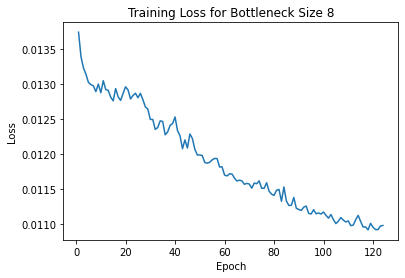

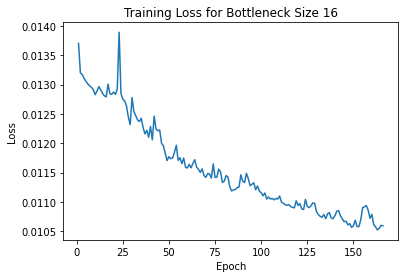

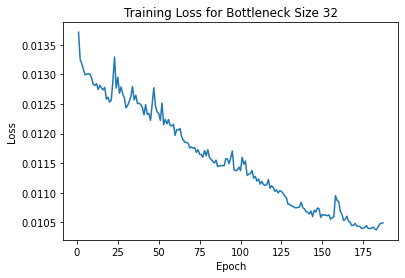

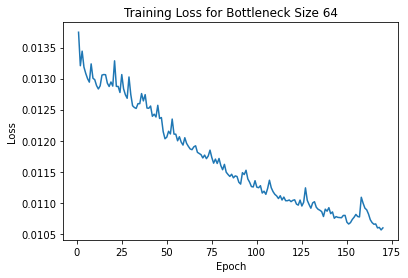

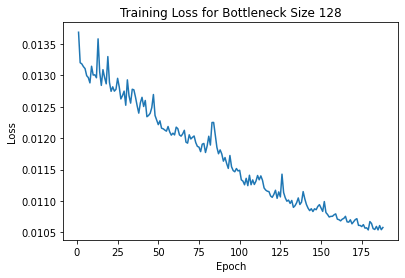

In [31]:
fig, ax = plt.subplots()
for bottleneck in bottlenecks:
	
	plot_training_loss(bottleneck)
	plt.show()

### Performance

We then tested the performances on each bottleneck.

In [32]:
# sample = user_ratings.sample(100)

We used the masking technique on the rows for each bottleneck.

In [36]:
bottleneck_results = [test_bottleneck(user_ratings, device, k) for k in bottlenecks]
# bottleneck_results = test_bottleneck(user_ratings, device, 5)

Testing bottleneck 128


counted how many rows that match the original one. The resulting `coo_matrix` shows

In [37]:
user_mapping, book_mapping = get_mappings(user_ratings)

In [39]:
# performance_results = pd.DataFrame(columns=['RMSE', 'Non-Zero Count'])
for result in bottleneck_results:
    print(f'RMSE: {result[0]:.4f}')
    user_label = 'A30TK6U7DNS82R'
    book_label = '0826414346'
    value = get_value_from_coo(result[1], user_label, book_label, user_mapping, book_mapping)
    print(f"Predicted for user '{user_label}' and book '{book_label}': {value}")
    value = get_value_from_coo(result[2], user_label, book_label, user_mapping, book_mapping)
    print(f"Value for user '{user_label}' and book '{book_label}': {value}")


RMSE: 0.1125
Predicted for user 'A30TK6U7DNS82R' and book '0826414346': 0.00223697442561388
Value for user 'A30TK6U7DNS82R' and book '0826414346': 5.0


In [57]:
user_label = 'A30TK6U7DNS82R'
book_label = '0826414346'
value = get_value_from_coo(coo, user_label, book_label, user_mapping, book_mapping)
print(f"Value for user '{user_label}' and book '{book_label}': {value}")

Value for user 'A30TK6U7DNS82R' and book '0826414346': 3


So, the RMSE, the trainig loss and inference in the sample reveals bottleneck size of 16 is the optimal choice.

In [66]:
test16 = True

In [71]:
import pickle
if not test16:
    b16result = bottleneck_results[1]
    pickle.dump(b16result, open('k=16.pkl', 'wb'))
else:
    file = open('k=16.pkl', 'rb')
    b16result = pickle.load(file)
    

In [72]:
b16result

(0.10208989,
 <6842x92327 sparse matrix of type '<class 'numpy.float32'>'
 	with 406032 stored elements in COOrdinate format>,
 <6842x92327 sparse matrix of type '<class 'numpy.float64'>'
 	with 406032 stored elements in COOrdinate format>)

### Denoising Autoencoder

### PCA and k-means clustering

So, the data analyis